
### Dog Breed Classification

In this notebook,I built a model to identify dog breeds in an image. 


We will use the [Kaggle's Dog Breed Dataset](https://www.kaggle.com/c/dog-breed-identification) dataset for training. With 120 breeds of dogs and a limited number training images per class, you might find the problem more, err, ruff than you anticipated. 

To speed things up, we will apply [Transfer Learning](https://cs231n.github.io/transfer-learning/) by building new layers on top of the Xception model pre-trained on ImageNet to classify the top 10 dog breeds. *Note: We have reduced the number of classes (i.e. dog breeds) to 10 to fit the model in a CPU machine.*

We will:
- Preprocess images data for computer vision tasks
- Transfer Learning: build new layers on top of the pretrained Xception model using Keras and Tensorflow
- Evaluate our model on the test set
- Run the model on new dog images from the web!



## Initial Setup

Let's start by importing some packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from tqdm import tqdm
from os import listdir, makedirs
from os.path import join

## Training Parameters

Here we define the hyperparameters for training our model. We recommend keeping the defaults for your first run 🙂

In [18]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 32  # Number of images used in each iteration
    EPOCHS = 30  # Number of passes through entire dataset
    print("GPU")
    
# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 4
    EPOCHS = 10
    print("CPU")

CPU


## Data

*Note:* I have set the `NUM_CLASSES` variable to 10 to keep only the Top 10 dog breeds to train the model on a CPU machine in a reasonable time.

In [3]:
# Keep only the first 10 classes
NUM_CLASSES = 10 

data_dir = 'data/' # ADD path/to/dataset
labels = pd.read_csv(join(data_dir, 'labels.csv')) # EDIT WITH YOUR LABELS FILE NAME
print("Total number of images in the dataset: {}".format(len(listdir(join(data_dir, 'train'))))) 

print("Top {} labels (sorted by number of samples)".format(NUM_CLASSES))
(labels
 .groupby("breed")
 .count()
 .sort_values("id", ascending=False)
 .head(NUM_CLASSES)
)

Total number of images in the dataset: 10222
Top 10 labels (sorted by number of samples)


,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


### Transfer learning and data augmentation

This is the list of the top labels(dog breeds) sorted by the number of available samples in the dataset. If you notice, we only have ~100 examples of each breed - not much to train a deep learning model from scratch. 

Since we have only a few samples per label, we will
- Set up a Transfer Learning task using the Xception model (pre-trained on ImageNet)
- Use [data augmentation](https://en.wikipedia.org/wiki/Convolutional_neural_network#Artificial_data) to artificially increase the number of training images. We do this by manipulating (scaling, zooming, rotating, etc.) the input images.


In [4]:
# Creating dataframe

selected_breeds_list = list(labels.groupby("breed").count().sort_values("id", ascending=False).head(NUM_CLASSES).index)

selected_breeds = labels[labels['breed'].isin(selected_breeds_list)]
selected_breeds.reset_index(drop=True, inplace=True)
selected_breeds

,id,breed
0,003df8b8a8b05244b1d920bb6cf451f9,basenji
1,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
2,00693b8bc2470375cc744a6391d397ec,maltese_dog
3,0162b3e0144fb1d1ab82fbff3ace9938,shih-tzu
4,01b36cb1b80ab8c3a7d2b7128ad21bdc,samoyed
...,...,...
1136,ff54d45962b3123bb67052e8e29a60e7,basenji
1137,ff7d9c08091acc3b18b869951feeb013,maltese_dog
1138,ffa0055ec324829882186bae29491645,maltese_dog
1139,ffa4e1bf959425bad9228b04af40ac76,basenji


In [5]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to categorical columns
selected_breeds['breed_enc'] = le.fit_transform(selected_breeds['breed'])

# Display the DataFrame after label encoding
print(selected_breeds)

                                    id               breed  breed_enc
0     003df8b8a8b05244b1d920bb6cf451f9             basenji          1
1     0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound          8
2     00693b8bc2470375cc744a6391d397ec         maltese_dog          5
3     0162b3e0144fb1d1ab82fbff3ace9938            shih-tzu          9
4     01b36cb1b80ab8c3a7d2b7128ad21bdc             samoyed          7
...                                ...                 ...        ...
1136  ff54d45962b3123bb67052e8e29a60e7             basenji          1
1137  ff7d9c08091acc3b18b869951feeb013         maltese_dog          5
1138  ffa0055ec324829882186bae29491645         maltese_dog          5
1139  ffa4e1bf959425bad9228b04af40ac76             basenji          1
1140  ffcffab7e4beef9a9b8076ef2ca51909             samoyed          7

[1141 rows x 3 columns]


C:\Users\admin\AppData\Local\Temp\ipykernel_12684\2172844988.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_breeds['breed_enc'] = le.fit_transform(selected_breeds['breed'])


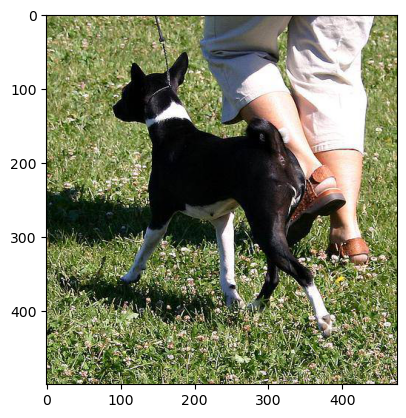

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the image using Pillow
img = Image.open('data/train/'+selected_breeds['id'][0]+'.jpg')

# Display the image using plt
plt.imshow(img)
plt.show()


## Train - Val Split

We split the dataset into two sets, one for training and one for validation. Splitting the dataset is a common step when the validation and/or test sets are not provided.

In [7]:
from sklearn.model_selection import train_test_split

train_idx, valid_idx, ytr, yv = train_test_split(selected_breeds['id'], selected_breeds['breed_enc'], test_size=0.20, random_state=104, shuffle=True)

# Resetting Indices
train_idx.reset_index(drop=True, inplace=True)
valid_idx.reset_index(drop=True, inplace=True)
ytr.reset_index(drop=True, inplace=True)
yv.reset_index(drop=True, inplace=True)

## Data Preprocessing

Before feeding the data into the model, we have to preprocess the images.

- The `xception.preprocess_input` method will normalize the value of each pixel to a number between -1 and 1, sample-wise.

In [8]:
# Image Preprocessing for inputting into Xception model
def img_preprocessing_fun(idx, INPUT_SIZE, path = 'data/train/'):
    
    import tensorflow as tf
    
    img_array = np.zeros((len(idx), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
    for i, img_id in tqdm(enumerate(idx)):
        img = Image.open(path+img_id+'.jpg')  # Read Image
        img_resized = img.resize((INPUT_SIZE, INPUT_SIZE))
        x = tf.keras.applications.xception.preprocess_input(np.array(img_resized) * 255)  # Assuming 'image' is a tensor or numpy array with shape (height, width, 3) and values in the range [0, 255]
        img_array[i] = x
        
    return img_array

In [9]:
# DATA LOADER
Xtr = img_preprocessing_fun(train_idx, INPUT_SIZE = 299)
Xv = img_preprocessing_fun(valid_idx, INPUT_SIZE = 299)

912it [00:06, 143.61it/s]
229it [00:01, 161.55it/s]


In [10]:
from tensorflow.keras.utils import to_categorical

# Convert integer labels to one-hot encoding
ytr = to_categorical(ytr, num_classes=10)  
yv = to_categorical(yv, num_classes=10)

print('Train (images, H, W, C):', Xtr.shape,
      '\nVal (images, H, W, C):', Xv.shape, 
      '\n\nTrain samples (images, labels)', ytr.shape,
      '\nValidation samples (images, labels)', yv.shape)

Train (images, H, W, C): (912, 299, 299, 3) 
Val (images, H, W, C): (229, 299, 299, 3) 

Train samples (images, labels) (912, 10) 
Validation samples (images, labels) (229, 10)


## Model definition

To speed things up, we will apply Transfer Learning by building new layers on top of the pre-trained Xception model. 

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*LQAC3xL5XL1x8TsIOChM7A.jpeg" width="600" height="600" align="center"/>

*Image from [medium](https://medium.com/@saba99/xception-cd1adc84290f)*

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

INPUT_SIZE = 299

# Load the pretrained Xception model (without top classifier) 
base_model = Xception(include_top=False, weights='pretrained-model/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Freeze the convolutional base so it doesn't get trained
base_model.trainable = False

# Define input layer
inputs = layers.Input(shape=(INPUT_SIZE, INPUT_SIZE, 3))

# Pass through the Xception base model
x = base_model(inputs)

# Using global avg pooling to summarize the info in each channel
x = GlobalAveragePooling2D()(x)

# Adding a fully-connected layer with NUM_CLASSES units
outputs = Dense(NUM_CLASSES, activation='softmax')(x)  # NUM_CLASSES = number of output classes

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

In [20]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.Adamax(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,881,970 (79.66 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

## Train CNN model


*Note*: The model can start overfitting after few epochs, since we're already starting from a pre-trained Xception model.

In [21]:
# TRAINING

hist = model.fit(Xtr, ytr, validation_data=(Xv, yv), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 195s 823ms/step - accuracy: 0.1040 - loss: 2.2974 - val_accuracy: 0.2751 - val_loss: 2.1379
Epoch 2/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 181s 793ms/step - accuracy: 0.3988 - loss: 2.0730 - val_accuracy: 0.5153 - val_loss: 1.9662
Epoch 3/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 185s 811ms/step - accuracy: 0.5499 - loss: 1.9022 - val_accuracy: 0.6594 - val_loss: 1.8171
Epoch 4/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 184s 810ms/step - accuracy: 0.6699 - loss: 1.7725 - val_accuracy: 0.6900 - val_loss: 1.6875
Epoch 5/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 201s 881ms/step - accuracy: 0.7310 - loss: 1.6252 - val_accuracy: 0.7293 - val_loss: 1.5702
Epoch 6/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 204s 897ms/step - accuracy: 0.7127 - loss: 1.5409 - val_accuracy: 0.7467 - val_loss: 1.4637
Epoch 7/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 189s 828ms/step - accuracy: 0.7601 - loss: 1.4103 - val_accuracy: 0.7467 - val_loss: 1.3725
Epoch 8/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 188s 826ms/step - accuracy: 0.7587 -

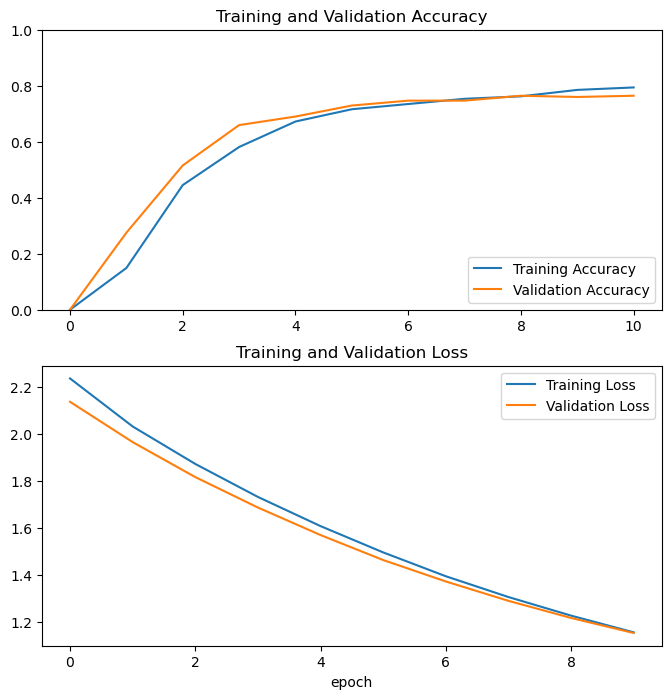

In [22]:
# Plotting Accuracy and Loss to check the model behaviour

acc      = [0.]
val_acc  = [0.]
loss     = [0.]
val_loss = [0.]

acc      += hist.history['accuracy']
val_acc  += hist.history['val_accuracy']
loss     += hist.history['loss']
val_loss += hist.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

As expected, Model has started performing better on training set as compared to validation set that means after 7 epochs, model has started overfitting on training set as training accuracy is more than validation accuracy after 7 epochs.

## Evaluate on validation set

In [23]:
# EVAL
probabilities = model.predict(Xv)

8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step


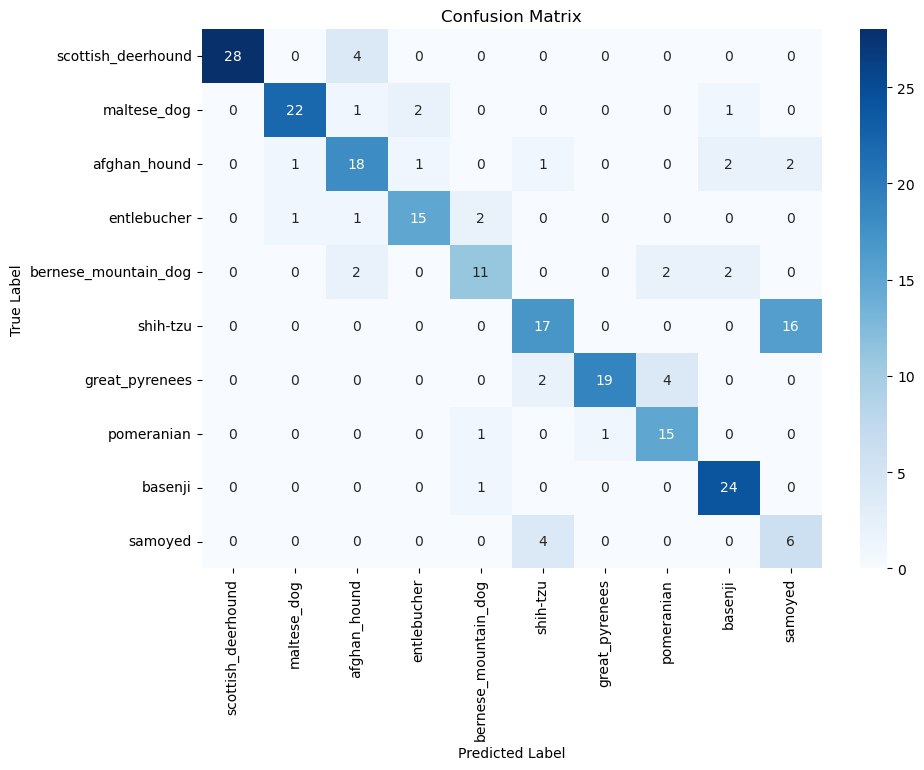

In [24]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cnf_matrix = confusion_matrix(np.argmax(probabilities,axis=1), np.argmax(yv, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=selected_breeds_list, yticklabels=selected_breeds_list)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [25]:
# Print Precision Recall F1-Score Report
from sklearn.metrics import classification_report

report = classification_report(np.argmax(probabilities,axis=1), np.argmax(yv, axis=1), target_names=selected_breeds_list)
print(report)

                      precision    recall  f1-score   support

  scottish_deerhound       1.00      0.88      0.93        32
         maltese_dog       0.92      0.85      0.88        26
        afghan_hound       0.69      0.72      0.71        25
         entlebucher       0.83      0.79      0.81        19
bernese_mountain_dog       0.73      0.65      0.69        17
            shih-tzu       0.71      0.52      0.60        33
      great_pyrenees       0.95      0.76      0.84        25
          pomeranian       0.71      0.88      0.79        17
             basenji       0.83      0.96      0.89        25
             samoyed       0.25      0.60      0.35        10

            accuracy                           0.76       229
           macro avg       0.76      0.76      0.75       229
        weighted avg       0.80      0.76      0.77       229



## Results

- With every epoch, training and validation accuracy is increasing that ended at 80.62% and 76.42% after 10 epochs.
- The accuracy of model can be increased further by using more computational resources where the traing would be alot faster.
- Data Augmentation layer can be added which will increase the number of training images and prevents overfitting. 
- More layers can be added after the base model layers or last few layers of base model can be be trained by making them trainable.